# Resume Transformer Workflow Agent using LangGraph

This notebook implements a complete resume processing workflow using LangGraph and OpenAI's GPT-4o-mini model.

## Workflow Steps:
1. **Parse**: Extract raw text from resume files (PDF, DOCX, TXT)
2. **Extract**: Use LLM to extract structured data into JSON
3. **Validate & Enrich**: Clean data, calculate experience, standardize skills
4. **Store**: Insert structured data into database


## Import Required Libraries

Installing required libraries.

In [1]:
import os
import json
import re
import sqlite3
from datetime import datetime
from typing import TypedDict, Optional, List, Dict, Any
from pathlib import Path

# Document parsing
import PyPDF2
import docx

# LangGraph
from langgraph.graph import StateGraph, END

# OpenAI
from openai import OpenAI

from dotenv import load_dotenv
load_dotenv()
# Access the variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Set up OpenAI client
# Make sure to set your OPENAI_API_KEY environment variable

client = OpenAI(api_key=OPENAI_API_KEY)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Define State Schema

The state will be passed between all agents in the workflow.

In [2]:
class ResumeState(TypedDict):
    """State schema for the resume transformation workflow"""
    # Input
    file_path: str
    file_type: str
    
    # Step 1: Parse
    raw_text: Optional[str]
    parse_error: Optional[str]
    
    # Step 2: Extract
    structured_data: Optional[Dict[str, Any]]
    extract_error: Optional[str]
    
    # Step 3: Validate & Enrich
    validated_data: Optional[Dict[str, Any]]
    validation_error: Optional[str]
    
    # Step 3.5: Human Review (HITL)
    human_approved: Optional[bool]
    human_review_notes: Optional[str]
    
    # Step 4: Store
    database_id: Optional[int]
    store_error: Optional[str]
    
    # Metadata
    status: str
    messages: List[str]

print("✓ State schema defined!")

✓ State schema defined!


## Step 1: Parse Agent

Extracts raw text from PDF, DOCX, or TXT files.

In [3]:
def parse_pdf(file_path: str) -> str:
    """Extract text from PDF file, with OCR fallback for image-based PDFs"""
    text = ""
    try:
        # First, try regular text extraction
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        
        # If no text was extracted, the PDF is likely image-based, try OCR
        if not text.strip():
            print("   ⚠️ No text found in PDF - attempting OCR extraction...")
            try:
                from pdf2image import convert_from_path
                import pytesseract
                
                # Convert PDF pages to images
                images = convert_from_path(file_path)
                
                # Perform OCR on each page
                for i, image in enumerate(images):
                    page_text = pytesseract.image_to_string(image)
                    text += page_text + "\n"
                    print(f"   ✓ OCR extracted {len(page_text)} characters from page {i+1}")
                
            except ImportError:
                raise Exception(
                    "PDF appears to be image-based but OCR libraries not available. "
                    "Install with: pip install pytesseract pdf2image pillow"
                )
            except Exception as e:
                raise Exception(f"OCR extraction failed: {str(e)}")
                
    except Exception as e:
        raise Exception(f"Error parsing PDF: {str(e)}")
    
    return text.strip()

def parse_docx(file_path: str) -> str:
    """Extract text from DOCX file"""
    try:
        doc = docx.Document(file_path)
        text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
    except Exception as e:
        raise Exception(f"Error parsing DOCX: {str(e)}")
    return text.strip()

def parse_txt(file_path: str) -> str:
    """Extract text from TXT file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
    except Exception as e:
        raise Exception(f"Error parsing TXT: {str(e)}")
    return text.strip()

def parse_agent(state: ResumeState) -> ResumeState:
    """
    Agent 1: Parse - Extract raw text from resume file
    """
    print(f"🔍 PARSE AGENT: Processing {state['file_path']}")
    
    try:
        file_type = state['file_type'].lower()
        
        if file_type == 'pdf':
            raw_text = parse_pdf(state['file_path'])
        elif file_type == 'docx':
            raw_text = parse_docx(state['file_path'])
        elif file_type == 'txt':
            raw_text = parse_txt(state['file_path'])
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
        
        state['raw_text'] = raw_text
        state['parse_error'] = None
        state['messages'].append(f"✓ Successfully parsed {len(raw_text)} characters from {file_type.upper()}")
        print(f"   ✓ Extracted {len(raw_text)} characters")
        
    except Exception as e:
        state['parse_error'] = str(e)
        state['messages'].append(f"✗ Parse error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Parse agent defined!")

✓ Parse agent defined!


## Step 2: Extract Agent

Uses gpt-4o-mini to extract structured data from the raw text.

In [4]:
def extract_agent(state: ResumeState) -> ResumeState:
    """
    Agent 2: Extract - Use LLM to extract structured data from raw text
    """
    print(f"🤖 EXTRACT AGENT: Analyzing resume with gpt-4o-mini")
    
    if state.get('parse_error'):
        state['extract_error'] = "Cannot extract: parsing failed"
        return state
    
    try:
        # Prepare the prompt for GPT-4o-mini
        system_prompt = """You are an expert resume parsing engine. Your task is to extract structured, normalized data from raw resume text and return it as VALID JSON ONLY.

        Follow these rules strictly:
        - Output MUST be a single JSON object and nothing else (no markdown, no comments).
        - If a field is missing or not found, use null or an empty array (never invent data).
        - Normalize capitalization (Title Case for names, companies, titles).
        - Deduplicate repeated skills, certifications, and languages.
        - Do not infer dates or employers unless explicitly stated.
        - Keep descriptions concise and factual.

        Extract the following schema exactly:

        {
        "contact": {
            "name": string | null,
            "email": string | null,
            "phone": string | null,
            "location": string | null,
            "linkedin": string | null,
            "github": string | null
        },
        "summary": string | null,
        "experience": [
            {
            "company": string | null,
            "title": string | null,
            "start_date": string | null,
            "end_date": string | null,
            "description": string | null,
            "responsibilities": [string]
            }
        ],
        "education": [
            {
            "institution": string | null,
            "degree": string | null,
            "field": string | null,
            "graduation_year": string | null
            }
        ],
        "skills": [string],
        "certifications": [string],
        "languages": [string]
        }

        Date formatting rules:
        - Use "YYYY-MM" when month is available.
        - Use "YYYY" if only the year is available.
        - Use "Present" for ongoing roles.

        Responsibilities should be concise bullet-style statements (max 1 sentence each)."""

        user_prompt = f"Resume text:\n\n{state['raw_text']}"
        
        # Call OpenAI API
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.1,
            response_format={"type": "json_object"}
        )
        
        # Parse the response
        extracted_text = response.choices[0].message.content
        structured_data = json.loads(extracted_text)
        
        state['structured_data'] = structured_data
        state['extract_error'] = None
        state['messages'].append("✓ Successfully extracted structured data using GPT-4o-mini")
        print(f"   ✓ Extracted data for: {structured_data.get('contact', {}).get('name', 'Unknown')}")
        
    except Exception as e:
        state['extract_error'] = str(e)
        state['messages'].append(f"✗ Extract error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Extract agent defined!")

✓ Extract agent defined!


## Step 3: Validate & Enrich Agent

Cleans data, calculates total years of experience, and standardizes skills.

In [18]:
# Standard skills taxonomy for normalization
STANDARD_SKILLS = {
    # Programming Languages
    'python': 'Python', 'java': 'Java', 'javascript': 'JavaScript', 'js': 'JavaScript',
    'typescript': 'TypeScript', 'c++': 'C++', 'c#': 'C#', 'ruby': 'Ruby',
    'go': 'Go', 'rust': 'Rust', 'swift': 'Swift', 'kotlin': 'Kotlin', 'php': 'PHP',
    
    # Frameworks
    'react': 'React', 'reactjs': 'React', 'angular': 'Angular', 'vue': 'Vue.js',
    'django': 'Django', 'flask': 'Flask', 'spring': 'Spring', 'nodejs': 'Node.js',
    'express': 'Express.js', 'fastapi': 'FastAPI',
    
    # Databases
    'sql': 'SQL', 'mysql': 'MySQL', 'postgresql': 'PostgreSQL', 'mongodb': 'MongoDB',
    'redis': 'Redis', 'oracle': 'Oracle', 'dynamodb': 'DynamoDB',
    
    # Cloud & DevOps
    'aws': 'AWS', 'azure': 'Azure', 'gcp': 'Google Cloud', 'docker': 'Docker',
    'kubernetes': 'Kubernetes', 'k8s': 'Kubernetes', 'terraform': 'Terraform',
    'jenkins': 'Jenkins', 'ci/cd': 'CI/CD', 'git': 'Git',
    
    # Data Science & ML
    'machine learning': 'Machine Learning', 'ml': 'Machine Learning',
    'deep learning': 'Deep Learning', 'tensorflow': 'TensorFlow',
    'pytorch': 'PyTorch', 'pandas': 'Pandas', 'numpy': 'NumPy',
    'scikit-learn': 'Scikit-learn', 'nlp': 'NLP',
    
    # Other
    'agile': 'Agile', 'scrum': 'Scrum', 'rest api': 'REST API',
    'graphql': 'GraphQL', 'microservices': 'Microservices'
}

def parse_date(date_str: str) -> Optional[datetime]:
    """Parse various date formats"""
    if not date_str or date_str.lower() in ['present', 'current', 'now']:
        return datetime.now()
    
    # Try different formats
    formats = ['%Y-%m', '%Y', '%m/%Y', '%B %Y', '%b %Y']
    for fmt in formats:
        try:
            return datetime.strptime(str(date_str).strip(), fmt)
        except:
            continue
    return None

def calculate_experience(experience_list: List[Dict]) -> float:
    """Calculate total years of experience"""
    total_months = 0
    
    for job in experience_list:
        start = parse_date(job.get('start_date', ''))
        end = parse_date(job.get('end_date', ''))
        
        if start and end:
            months = (end.year - start.year) * 12 + (end.month - start.month)
            total_months += max(0, months)
    
    return round(total_months / 12, 1)

def standardize_skills(skills: List[str]) -> List[str]:
    """Normalize skills to standard taxonomy"""
    standardized = set()
    
    for skill in skills:
        skill_lower = skill.lower().strip()
        # Check if skill matches standard taxonomy
        if skill_lower in STANDARD_SKILLS:
            standardized.add(STANDARD_SKILLS[skill_lower])
        else:
            # Keep original if not in taxonomy
            standardized.add(skill.strip())
    
    return sorted(list(standardized))

def clean_contact_info(contact: Dict) -> Dict:
    """Clean and validate contact information"""
    cleaned = {}
    
    # Clean email
    if contact.get('email'):
        email = contact['email'].strip().lower()
        if '@' in email:
            cleaned['email'] = email
    
    # Clean phone
    if contact.get('phone'):
        phone = re.sub(r'[^\d+\-() ]', '', contact['phone'])
        cleaned['phone'] = phone
    
    # Copy other fields
    for field in ['name', 'location', 'linkedin', 'github']:
        if contact.get(field):
            cleaned[field] = contact[field].strip()
    
    return cleaned

def validate_and_enrich_agent(state: ResumeState) -> ResumeState:
    """
    Agent 3: Validate & Enrich - Clean data, calculate experience, standardize skills
    """
    print(f"✨ VALIDATE & ENRICH AGENT: Processing data")
    
    if state.get('extract_error'):
        state['validation_error'] = "Cannot validate: extraction failed"
        return state
    
    try:
        data = state['structured_data'].copy()
        
        # Clean contact info
        if data.get('contact'):
            data['contact'] = clean_contact_info(data['contact'])
        
        # Calculate total experience
        if data.get('experience'):
            total_experience = calculate_experience(data['experience'])
            data['total_years_experience'] = total_experience
            print(f"   ✓ Calculated {total_experience} years of experience")
        
        # Standardize skills
        if data.get('skills'):
            original_count = len(data['skills'])
            data['skills'] = standardize_skills(data['skills'])
            print(f"   ✓ Standardized {original_count} skills to {len(data['skills'])} unique skills")
        
        # Add metadata
        data['processed_date'] = datetime.now().isoformat()
        data['data_version'] = '1.0'
        
        state['validated_data'] = data
        state['validation_error'] = None
        state['messages'].append("✓ Successfully validated and enriched data")
        
    except Exception as e:
        state['validation_error'] = str(e)
        state['messages'].append(f"✗ Validation error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Validate & Enrich agent defined!")

✓ Validate & Enrich agent defined!


## Step 4: Human Review Agent (HITL)

Visual grounding step for human-in-the-loop verification. Displays resume image alongside extracted data for review and correction.

In [46]:
# HTML-based Human Review Interface
import webbrowser
import base64
from io import BytesIO
from pathlib import Path
import tempfile

def get_resume_image_base64(file_path: str, file_type: str) -> str:
    """Convert resume to base64 image for embedding in HTML"""
    try:
        if file_type == 'pdf':
            from pdf2image import convert_from_path
            images = convert_from_path(file_path, first_page=1, last_page=1, dpi=200)
            resume_image = images[0]
        elif file_type in ['jpg', 'jpeg', 'png']:
            from PIL import Image
            resume_image = Image.open(file_path)
        else:
            return None
        
        # Convert to base64
        buffered = BytesIO()
        resume_image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"data:image/png;base64,{img_str}"
    except Exception as e:
        print(f"⚠️ Could not generate visual preview: {str(e)}")
        return None

def create_review_html_file(file_path: str, file_type: str, validated_data: Dict, output_path: str, result_file: str) -> str:
    """Create HTML interface for human review"""
    
    # Get resume image
    img_data = get_resume_image_base64(file_path, file_type)
    
    # Extract data
    contact = validated_data.get('contact', {})
    skills = validated_data.get('skills', [])
    certifications = validated_data.get('certifications', [])
    education = validated_data.get('education', [])
    experience = validated_data.get('experience', [])
    
    # Build education HTML (editable)
    education_html = ""
    for idx, edu in enumerate(education):
        education_html += f"""
        <div style="margin-bottom: 15px; padding: 15px; background: #f8f9fa; border-radius: 5px; border: 1px solid #dee2e6;">
            <div style="font-weight: 600; color: #1976d2; margin-bottom: 8px;">Education #{idx + 1}</div>
            <input type="text" class="edit-input" id="edu_{idx}_degree" value="{edu.get('degree', '')}" placeholder="Degree">
            <input type="text" class="edit-input" id="edu_{idx}_field" value="{edu.get('field', '')}" placeholder="Field of Study">
            <input type="text" class="edit-input" id="edu_{idx}_institution" value="{edu.get('institution', '')}" placeholder="Institution">
            <input type="text" class="edit-input" id="edu_{idx}_year" value="{edu.get('graduation_year', '')}" placeholder="Graduation Year">
        </div>
        """
    
    # Build experience HTML (editable)
    experience_html = ""
    for idx, exp in enumerate(experience):
        experience_html += f"""
        <div style="margin-bottom: 15px; padding: 15px; background: #f8f9fa; border-radius: 5px; border: 1px solid #dee2e6;">
            <div style="font-weight: 600; color: #1976d2; margin-bottom: 8px;">Experience #{idx + 1}</div>
            <input type="text" class="edit-input" id="exp_{idx}_title" value="{exp.get('title', '')}" placeholder="Job Title">
            <input type="text" class="edit-input" id="exp_{idx}_company" value="{exp.get('company', '')}" placeholder="Company">
            <div style="display: flex; gap: 10px;">
                <input type="text" class="edit-input" style="flex: 1;" id="exp_{idx}_start" value="{exp.get('start_date', '')}" placeholder="Start Date (YYYY-MM)">
                <input type="text" class="edit-input" style="flex: 1;" id="exp_{idx}_end" value="{exp.get('end_date', '')}" placeholder="End Date (YYYY-MM or Present)">
            </div>
            <textarea class="edit-input" id="exp_{idx}_description" rows="3" placeholder="Description">{exp.get('description', '')}</textarea>
        </div>
        """
    
    # Build skills textarea (editable - one per line)
    skills_text = "\n".join(skills)
    
    # Build certifications textarea (editable - one per line)
    certifications_text = "\n".join(certifications)
    
    # Image section
    image_section = ""
    if img_data:
        image_section = f"""
        <div style="flex: 1; background: #f5f5f5; padding: 20px; overflow-y: auto; max-height: 80vh; border-right: 2px solid #e0e0e0;">
            <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 15px;">
                <h2 style="margin: 0; color: #1976d2;">📄 Resume Document</h2>
                <div style="display: flex; gap: 8px;">
                    <button onclick="zoomIn()" style="padding: 8px 12px; border: 1px solid #1976d2; background: white; color: #1976d2; border-radius: 4px; cursor: pointer; font-weight: 600; transition: all 0.2s;" onmouseover="this.style.background='#1976d2'; this.style.color='white';" onmouseout="this.style.background='white'; this.style.color='#1976d2';">🔍+ Zoom In</button>
                    <button onclick="zoomOut()" style="padding: 8px 12px; border: 1px solid #1976d2; background: white; color: #1976d2; border-radius: 4px; cursor: pointer; font-weight: 600; transition: all 0.2s;" onmouseover="this.style.background='#1976d2'; this.style.color='white';" onmouseout="this.style.background='white'; this.style.color='#1976d2';">🔍- Zoom Out</button>
                    <button onclick="fitToWindow()" style="padding: 8px 12px; border: 1px solid #1976d2; background: white; color: #1976d2; border-radius: 4px; cursor: pointer; font-weight: 600; transition: all 0.2s;" onmouseover="this.style.background='#1976d2'; this.style.color='white';" onmouseout="this.style.background='white'; this.style.color='#1976d2';">⬜ Fit to Window</button>
                </div>
            </div>
            <div id="resume-image-container" style="text-align: center; overflow: auto;">
                <img id="resume-image" src="{img_data}" style="width: 100%; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); transition: transform 0.2s;">
            </div>
        </div>
        """
    else:
        image_section = """
        <div style="flex: 1; background: #f5f5f5; padding: 20px; display: flex; align-items: center; justify-content: center; border-right: 2px solid #e0e0e0;">
            <div style="text-align: center; color: #666;">
                <div style="font-size: 48px; margin-bottom: 10px;">📄</div>
                <div>Resume preview not available</div>
            </div>
        </div>
        """
    
    html = f"""
    <div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;">
        <style>
            .edit-input {{
                width: 100%;
                padding: 10px;
                margin: 8px 0;
                border: 1px solid #ddd;
                border-radius: 5px;
                font-size: 14px;
                box-sizing: border-box;
            }}
            .edit-input:focus {{
                outline: none;
                border-color: #1976d2;
                box-shadow: 0 0 0 2px rgba(25,118,210,0.1);
            }}
            .field-label {{
                font-weight: 600;
                color: #333;
                margin-bottom: 4px;
                font-size: 13px;
                text-transform: uppercase;
                letter-spacing: 0.5px;
            }}
            .section-title {{
                font-size: 18px;
                font-weight: 700;
                color: #1976d2;
                margin: 25px 0 15px 0;
                padding-bottom: 8px;
                border-bottom: 2px solid #e3f2fd;
            }}
            .btn {{
                padding: 12px 24px;
                border: none;
                border-radius: 6px;
                font-size: 15px;
                font-weight: 600;
                cursor: pointer;
                transition: all 0.2s;
                margin: 10px 10px 0 0;
            }}
            .btn-approve {{
                background: #4caf50;
                color: white;
            }}
            .btn-approve:hover {{
                background: #45a049;
                transform: translateY(-1px);
                box-shadow: 0 4px 8px rgba(0,0,0,0.2);
            }}
            .btn-reject {{
                background: #f44336;
                color: white;
            }}
            .btn-reject:hover {{
                background: #da190b;
                transform: translateY(-1px);
                box-shadow: 0 4px 8px rgba(0,0,0,0.2);
            }}
        </style>
        
        <div style="background: #1976d2; color: white; padding: 20px; border-radius: 8px 8px 0 0; margin-bottom: 0;">
            <h1 style="margin: 0; font-size: 24px;">👁️ Human Review - Visual Grounding</h1>
            <p style="margin: 8px 0 0 0; opacity: 0.9;">Review extracted data against the original resume and make corrections if needed</p>
        </div>
        
        <div style="display: flex; border: 2px solid #e0e0e0; border-top: none; border-radius: 0 0 8px 8px; background: white;">
            {image_section}
            
            <div style="flex: 1; padding: 30px; overflow-y: auto; max-height: 80vh;">
                <div class="section-title">📝 Contact Information (Editable)</div>
                
                <div class="field-label">Full Name</div>
                <input type="text" class="edit-input" id="name_input" value="{contact.get('name', '')}" placeholder="Full Name">
                
                <div class="field-label">Email Address</div>
                <input type="email" class="edit-input" id="email_input" value="{contact.get('email', '')}" placeholder="email@example.com">
                
                <div class="field-label">Phone Number</div>
                <input type="tel" class="edit-input" id="phone_input" value="{contact.get('phone', '')}" placeholder="+1 (555) 123-4567">
                
                <div class="field-label">Location</div>
                <input type="text" class="edit-input" id="location_input" value="{contact.get('location', '')}" placeholder="City, State">
                
                <div class="field-label">LinkedIn Profile</div>
                <input type="url" class="edit-input" id="linkedin_input" value="{contact.get('linkedin', '')}" placeholder="linkedin.com/in/username">
                
                <div class="field-label">GitHub Profile</div>
                <input type="url" class="edit-input" id="github_input" value="{contact.get('github', '')}" placeholder="github.com/username">
                
                <div class="section-title">💼 Professional Summary</div>
                <div style="background: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 15px;">
                    <div style="font-size: 16px;"><strong>Total Experience:</strong> {validated_data.get('total_years_experience', 0)} years</div>
                </div>
                
                <div class="section-title">🛠️ Skills ({len(skills)}) - Editable</div>
                <div class="field-label">Skills (one per line)</div>
                <textarea class="edit-input" id="skills_input" rows="6" placeholder="Enter skills, one per line">{skills_text}</textarea>
                
                <div class="section-title">📜 Certifications ({len(certifications)}) - Editable</div>
                <div class="field-label">Certifications (one per line)</div>
                <textarea class="edit-input" id="certifications_input" rows="4" placeholder="Enter certifications, one per line">{certifications_text}</textarea>
                
                <div class="section-title">🎓 Education ({len(education)}) - Editable</div>
                {education_html}
                
                <div class="section-title">💼 Experience ({len(experience)}) - Editable</div>
                {experience_html}
                
                <div class="section-title">📋 Review Notes</div>
                <textarea class="edit-input" id="notes_input" rows="4" placeholder="Add any review notes or corrections needed..." style="resize: vertical; min-height: 80px;"></textarea>
                
                <div style="margin-top: 30px; padding-top: 20px; border-top: 2px solid #e0e0e0;">
                    <button class="btn btn-approve" onclick="approveData()">✓ Approve & Continue</button>
                    <button class="btn btn-reject" onclick="rejectData()">✗ Reject & Skip</button>
                    <div id="status_message" style="margin-top: 15px; padding: 12px; border-radius: 5px; display: none;"></div>
                </div>
            </div>
        </div>
        
        <script>
            window.reviewState = {{
                approved: null,
                data: {{}}
            }};
            
            // Zoom functionality
            let currentZoom = 100;
            const zoomStep = 20;
            const minZoom = 50;
            const maxZoom = 300;
            
            function zoomIn() {{
                if (currentZoom < maxZoom) {{
                    currentZoom += zoomStep;
                    applyZoom();
                }}
            }}
            
            function zoomOut() {{
                if (currentZoom > minZoom) {{
                    currentZoom -= zoomStep;
                    applyZoom();
                }}
            }}
            
            function fitToWindow() {{
                currentZoom = 100;
                applyZoom();
            }}
            
            function applyZoom() {{
                const img = document.getElementById('resume-image');
                if (img) {{
                    img.style.width = currentZoom + '%';
                }}
            }}
            
            function approveData() {{
                window.reviewState.approved = true;
                
                // Collect contact data
                window.reviewState.data = {{
                    contact: {{
                        name: document.getElementById('name_input').value,
                        email: document.getElementById('email_input').value,
                        phone: document.getElementById('phone_input').value,
                        location: document.getElementById('location_input').value,
                        linkedin: document.getElementById('linkedin_input').value,
                        github: document.getElementById('github_input').value
                    }},
                    skills: document.getElementById('skills_input').value.split('\\n').filter(s => s.trim() !== ''),
                    certifications: document.getElementById('certifications_input').value.split('\\n').filter(s => s.trim() !== ''),
                    education: [],
                    experience: [],
                    notes: document.getElementById('notes_input').value
                }};
                
                // Collect education data
                let eduIdx = 0;
                while (document.getElementById('edu_' + eduIdx + '_degree')) {{
                    window.reviewState.data.education.push({{
                        degree: document.getElementById('edu_' + eduIdx + '_degree').value,
                        field: document.getElementById('edu_' + eduIdx + '_field').value,
                        institution: document.getElementById('edu_' + eduIdx + '_institution').value,
                        graduation_year: document.getElementById('edu_' + eduIdx + '_year').value
                    }});
                    eduIdx++;
                }}
                
                // Collect experience data
                let expIdx = 0;
                while (document.getElementById('exp_' + expIdx + '_title')) {{
                    window.reviewState.data.experience.push({{
                        title: document.getElementById('exp_' + expIdx + '_title').value,
                        company: document.getElementById('exp_' + expIdx + '_company').value,
                        start_date: document.getElementById('exp_' + expIdx + '_start').value,
                        end_date: document.getElementById('exp_' + expIdx + '_end').value,
                        description: document.getElementById('exp_' + expIdx + '_description').value
                    }});
                    expIdx++;
                }}
                
                var msg = document.getElementById('status_message');
                msg.style.display = 'block';
                msg.style.background = '#d4edda';
                msg.style.color = '#155724';
                msg.style.border = '1px solid #c3e6cb';
                msg.innerHTML = '✅ <strong>Data Approved!</strong> Please click Continue below the interface.';
            }}
            
            function rejectData() {{
                window.reviewState.approved = false;
                window.reviewState.data = {{
                    notes: document.getElementById('notes_input').value
                }};
                
                var msg = document.getElementById('status_message');
                msg.style.display = 'block';
                msg.style.background = '#f8d7da';
                msg.style.color = '#721c24';
                msg.style.border = '1px solid #f5c6cb';
                msg.innerHTML = '❌ <strong>Data Rejected.</strong> This record will NOT be stored.<br><br>Click the button below to save your decision.';
            }}
            
            function saveDecision() {{
                // Save decision to a JSON file that Python can read
                var data = JSON.stringify(window.reviewState);
                var blob = new Blob([data], {{type: 'application/json'}});
                var url = URL.createObjectURL(blob);
                var a = document.createElement('a');
                a.href = url;
                a.download = '{result_file}';
                a.click();
                
                // Also write to localStorage as backup
                localStorage.setItem('reviewState', data);
                
                // Update message
                var statusMsg = document.getElementById('status_message');
                if (statusMsg.style.display !== 'none') {{
                    statusMsg.innerHTML += '<br><br>📥 <strong>File Downloaded!</strong> Return to the notebook and press Enter to continue.';
                }}
            }}
        </script>
        <div style="text-center; padding: 20px; background: #f8f9fa; border-top: 2px solid #e0e0e0;">
            <button class="btn" style="background: #2196f3; color: white; font-size: 16px;" onclick="saveDecision()">💾 Save Decision & Continue</button>
            <p style="margin-top: 10px; color: #666; font-size: 13px;">After clicking above, return to your notebook and press Enter</p>
        </div>
    </div>
    """
    
    # Write HTML to file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html)
    
    return output_path


def human_review_agent(state: ResumeState) -> ResumeState:
    """
    Agent 3.5: Human Review - Display resume and allow corrections (HITL)
    """
    print(f"👁️ HUMAN REVIEW AGENT: Visual grounding and verification")
    
    if state.get('validation_error'):
        print("   ⚠️ Skipping review due to validation error")
        state['human_approved'] = False
        return state
    
    print("\n" + "="*80)
    print("VISUAL GROUNDING: Review extracted data against original resume")
    print("="*80 + "\n")
    
    # Create temporary files for HTML and result
    temp_dir = Path(tempfile.gettempdir()) / "resume_review"
    temp_dir.mkdir(exist_ok=True)
    
    html_file = temp_dir / "review.html"
    result_file = temp_dir / "review_result.json"
    
    # Clean up old result file if it exists
    if result_file.exists():
        result_file.unlink()
    
    # Create HTML file
    print("📄 Generating review interface...")
    create_review_html_file(
        state['file_path'],
        state['file_type'],
        state['validated_data'],
        str(html_file),
        result_file.name
    )
    
    # Open in browser
    print(f"🌐 Opening review interface in browser: {html_file}")
    webbrowser.open(f"file://{html_file}")
    
    # Wait for user to complete review
    print("\n⏳ Waiting for your decision in the browser...")
    print("👉 After clicking 'Approve' or 'Reject', save the downloaded file and press Enter here: ")
    input()
    
    # Try to read result from file
    import time
    max_attempts = 3
    attempt = 0
    approval_result = None
    
    # Fallback to manual input with validation
    print("\n" + "="*60)
    decision = ""
    while decision not in ['approve', 'reject']:
        decision = input("Enter your decision (approve/reject): ").lower().strip()
        if decision not in ['approve', 'reject']:
            print("⚠️ Invalid input. Please type 'approve' or 'reject' (without quotes)")
    
    if decision == 'approve':
        state['human_approved'] = True
        
        # Ask if user wants to input edited data
        has_edits = input("Did you make any edits? (yes/no): ").lower().strip()
        if has_edits == 'yes':
            print("\n📝 Please paste the edited data JSON (or press Enter to skip):")
            try:
                import json
                json_input = input()
                if json_input.strip():
                    edited_data = json.loads(json_input)
                    
                    # Merge edited contact data
                    if 'contact' in edited_data:
                        state['validated_data']['contact'].update(edited_data['contact'])
                    
                    # Update skills
                    if 'skills' in edited_data:
                        state['validated_data']['skills'] = edited_data['skills']
                    
                    # Update certifications
                    if 'certifications' in edited_data:
                        state['validated_data']['certifications'] = edited_data['certifications']
                    
                    # Update education
                    if 'education' in edited_data:
                        state['validated_data']['education'] = edited_data['education']
                    
                    # Update experience
                    if 'experience' in edited_data:
                        state['validated_data']['experience'] = edited_data['experience']
                    
                    print("   ✓ Edits applied to validated data")
            except Exception as e:
                print(f"   ⚠️ Could not parse edits: {e}")
        
        state['human_review_notes'] = input("Review notes (optional): ")
        state['messages'].append("✓ Human review: APPROVED (manual)")
        print("\n   ✓ Human review completed - APPROVED")
    else:
        state['human_approved'] = False
        state['human_review_notes'] = input("Rejection reason: ")
        state['messages'].append("✗ Human review: REJECTED")
        print("\n   ✗ Human review completed - REJECTED")
    
    return state 

## Step 5: Store Agent

Formats data into SQL and inserts into the database.

In [47]:
def initialize_database(db_path: str = "resume_ats.db"):
    """Initialize the ATS database with required tables"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create candidates table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS candidates (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            email TEXT,
            phone TEXT,
            location TEXT,
            linkedin TEXT,
            github TEXT,
            summary TEXT,
            total_years_experience REAL,
            processed_date TEXT,
            data_version TEXT,
            human_approved BOOLEAN,
            human_review_notes TEXT,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    ''')
    
    # Add missing columns to existing table (for backward compatibility)
    try:
        cursor.execute("ALTER TABLE candidates ADD COLUMN human_approved BOOLEAN")
        print("   ✓ Added human_approved column to existing database")
    except sqlite3.OperationalError:
        pass  # Column already exists
    
    try:
        cursor.execute("ALTER TABLE candidates ADD COLUMN human_review_notes TEXT")
        print("   ✓ Added human_review_notes column to existing database")
    except sqlite3.OperationalError:
        pass  # Column already exists
    
    # Create experience table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS experience (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            company TEXT,
            title TEXT,
            start_date TEXT,
            end_date TEXT,
            description TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create education table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS education (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            institution TEXT,
            degree TEXT,
            field TEXT,
            graduation_year TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create skills table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS skills (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            skill TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create certifications table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS certifications (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            certification TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    conn.commit()
    conn.close()

def store_agent(state: ResumeState, db_path: str = "resume_ats.db") -> ResumeState:
    """
    Agent 4: Store - Insert structured data into database
    """
    print(f"💾 STORE AGENT: Saving to database")
    
    if state.get('validation_error'):
        state['store_error'] = "Cannot store: validation failed"
        return state
    
    # Check human approval status
    if state.get('human_approved') == False:
        state['store_error'] = "Cannot store: rejected by human reviewer"
        state['status'] = 'rejected'
        print(f"   ⚠️ Skipping storage - rejected by human reviewer")
        return state
    
    try:
        # Initialize database
        initialize_database(db_path)
        
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        data = state['validated_data']
        contact = data.get('contact', {})
        
        # Insert candidate with human review data
        cursor.execute('''
            INSERT INTO candidates 
            (name, email, phone, location, linkedin, github, summary, 
             total_years_experience, processed_date, data_version, 
             human_approved, human_review_notes)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            contact.get('name'),
            contact.get('email'),
            contact.get('phone'),
            contact.get('location'),
            contact.get('linkedin'),
            contact.get('github'),
            data.get('summary'),
            data.get('total_years_experience'),
            data.get('processed_date'),
            data.get('data_version'),
            state.get('human_approved'),
            state.get('human_review_notes')
        ))
        
        candidate_id = cursor.lastrowid
        
        # Insert experience
        for exp in data.get('experience', []):
            cursor.execute('''
                INSERT INTO experience 
                (candidate_id, company, title, start_date, end_date, description)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (
                candidate_id,
                exp.get('company'),
                exp.get('title'),
                exp.get('start_date'),
                exp.get('end_date'),
                exp.get('description')
            ))
        
        # Insert education
        for edu in data.get('education', []):
            cursor.execute('''
                INSERT INTO education 
                (candidate_id, institution, degree, field, graduation_year)
                VALUES (?, ?, ?, ?, ?)
            ''', (
                candidate_id,
                edu.get('institution'),
                edu.get('degree'),
                edu.get('field'),
                edu.get('graduation_year')
            ))
        
        # Insert skills
        for skill in data.get('skills', []):
            cursor.execute('''
                INSERT INTO skills (candidate_id, skill)
                VALUES (?, ?)
            ''', (candidate_id, skill))
        
        # Insert certifications
        for cert in data.get('certifications', []):
            cursor.execute('''
                INSERT INTO certifications (candidate_id, certification)
                VALUES (?, ?)
            ''', (candidate_id, cert))
        
        conn.commit()
        conn.close()
        
        state['database_id'] = candidate_id
        state['store_error'] = None
        state['status'] = 'completed'
        state['messages'].append(f"✓ Successfully stored candidate with ID {candidate_id}")
        print(f"   ✓ Stored candidate with ID: {candidate_id}")
        
    except Exception as e:
        state['store_error'] = str(e)
        state['status'] = 'failed'
        state['messages'].append(f"✗ Store error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Store agent defined!")

✓ Store agent defined!


## Build LangGraph Workflow

Now let's create the LangGraph state machine that orchestrates all agents.

✓ LangGraph workflow with HITL created successfully!


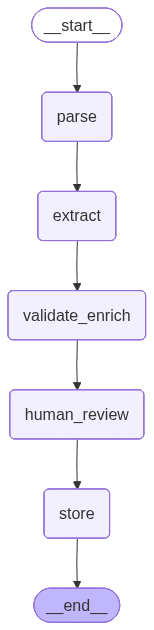

In [48]:
def should_continue(state: ResumeState) -> str:
    """
    Conditional edge to determine if workflow should continue or end
    """
    # Check if any previous step failed
    if state.get('parse_error'):
        return END
    if state.get('extract_error'):
        return END
    if state.get('validation_error'):
        return END
    if state.get('store_error'):
        return END
    
    return "continue"

def create_resume_workflow_with_hitl():
    """
    Create the LangGraph workflow with Human-in-the-Loop (HITL) review
    """
    # Initialize the state graph
    workflow = StateGraph(ResumeState)
    
    # Add nodes (agents) to the graph including HITL
    workflow.add_node("parse", parse_agent)
    workflow.add_node("extract", extract_agent)
    workflow.add_node("validate_enrich", validate_and_enrich_agent)
    workflow.add_node("human_review", human_review_agent)  # HITL step
    workflow.add_node("store", store_agent)
    
    # Define the flow: parse -> extract -> validate_enrich -> human_review -> store
    workflow.set_entry_point("parse")
    workflow.add_edge("parse", "extract")
    workflow.add_edge("extract", "validate_enrich")
    workflow.add_edge("validate_enrich", "human_review")  # Add HITL
    workflow.add_edge("human_review", "store")
    workflow.add_edge("store", END)
    
    # Compile the workflow
    app = workflow.compile()
    
    return app

# Create the workflow with HITL
resume_workflow_hitl = create_resume_workflow_with_hitl()

print("✓ LangGraph workflow with HITL created successfully!")

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
display(Image(resume_workflow_hitl.get_graph().draw_mermaid_png()))

## Main Execution Function

Function to process a resume through the complete workflow.

In [49]:
def process_resume_with_hitl(file_path: str, db_path: str = "resume_ats.db") -> Dict[str, Any]:
    """
    Process a resume through the complete workflow WITH Human-in-the-Loop review
    
    Args:
        file_path: Path to the resume file (PDF, DOCX, or TXT)
        db_path: Path to the SQLite database
    
    Returns:
        Dictionary with processing results and status
    """
    print("="*80)
    print(f"🚀 RESUME TRANSFORMER WORKFLOW (WITH HITL)")
    print("="*80)
    
    # Determine file type
    file_extension = Path(file_path).suffix.lower().replace('.', '')
    
    # Initialize state
    initial_state: ResumeState = {
        'file_path': file_path,
        'file_type': file_extension,
        'raw_text': None,
        'parse_error': None,
        'structured_data': None,
        'extract_error': None,
        'validated_data': None,
        'validation_error': None,
        'human_approved': None,
        'human_review_notes': None,
        'database_id': None,
        'store_error': None,
        'status': 'processing',
        'messages': []
    }
    
    # Run the workflow
    try:
        # Execute the workflow with HITL
        final_state = resume_workflow_hitl.invoke(initial_state)
        
        # Manually call store_agent with db_path
        if not final_state.get('validation_error') and final_state.get('human_approved') != False:
            final_state = store_agent(final_state, db_path)
        
        print("\n" + "="*80)
        print("📊 WORKFLOW SUMMARY")
        print("="*80)
        
        for message in final_state['messages']:
            print(f"  {message}")
        
        print(f"\n  Final Status: {final_state['status'].upper()}")
        
        if final_state.get('database_id'):
            print(f"  Database ID: {final_state['database_id']}")
        
        if final_state.get('human_approved') is not None:
            approval_status = "✓ APPROVED" if final_state.get('human_approved') else "✗ REJECTED"
            print(f"  Human Review: {approval_status}")
        
        print("="*80)
        
        return {
            'success': final_state['status'] == 'completed',
            'database_id': final_state.get('database_id'),
            'candidate_name': final_state.get('validated_data', {}).get('contact', {}).get('name'),
            'human_approved': final_state.get('human_approved'),
            'messages': final_state['messages'],
            'state': final_state
        }
        
    except Exception as e:
        print(f"\n❌ Workflow failed: {str(e)}")
        return {
            'success': False,
            'error': str(e),
            'messages': [f"Fatal error: {str(e)}"]
        }

print("✓ HITL execution function defined!")

✓ HITL execution function defined!


## Test the Workflow

Let's test the workflow with a sample resume from the data folder.

In [50]:
# Test HITL workflow with a sample resume
sample_resume = "data/AnuvaGoyal_Latex.pdf"

# Process with human review
result_hitl = process_resume_with_hitl(sample_resume)

🚀 RESUME TRANSFORMER WORKFLOW (WITH HITL)
🔍 PARSE AGENT: Processing data/AnuvaGoyal_Latex.pdf
   ✓ Extracted 4123 characters
🤖 EXTRACT AGENT: Analyzing resume with gpt-4o-mini
   ✓ Extracted data for: Anuva Goyal
✨ VALIDATE & ENRICH AGENT: Processing data
   ✓ Calculated 0.2 years of experience
   ✓ Standardized 14 skills to 14 unique skills
👁️ HUMAN REVIEW AGENT: Visual grounding and verification

VISUAL GROUNDING: Review extracted data against original resume

📄 Generating review interface...
🌐 Opening review interface in browser: /var/folders/bg/ql8wn08n167f8j9j723dzcfh0000gn/T/resume_review/review.html

⏳ Waiting for your decision in the browser...
👉 After clicking 'Approve' or 'Reject', save the downloaded file and press Enter here: 


   ✓ Human review completed - APPROVED
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 11
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 12

📊 WORKFLOW SUMMARY
  ✓ Successfully parsed 4123 characters from PDF
  ✓ S

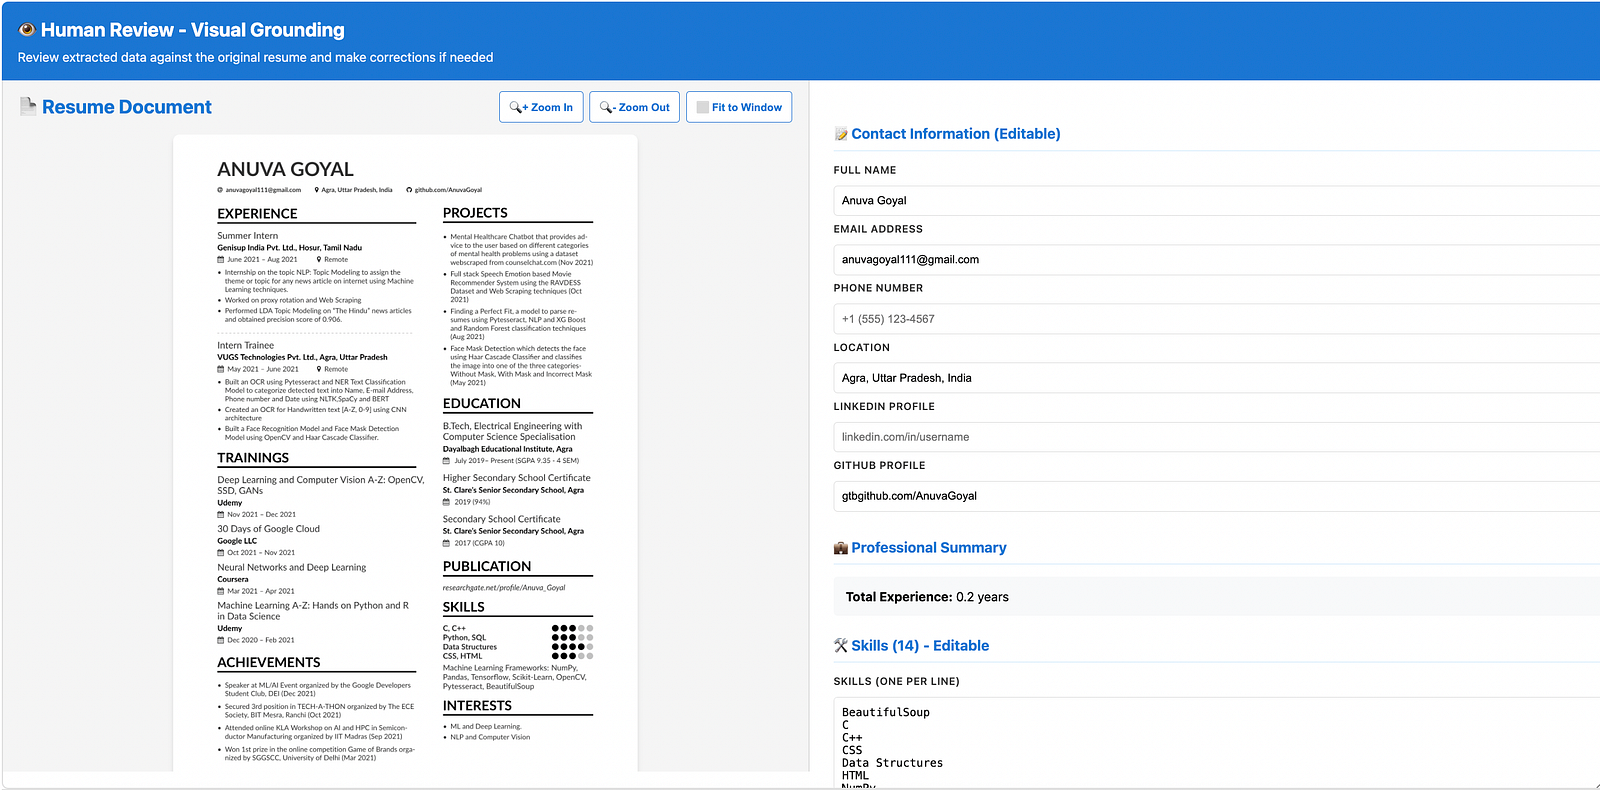

In [51]:
# Test HITL workflow with a sample resume
sample_resume = "data/candidate_042.pdf"

# Process with human review
result_hitl = process_resume_with_hitl(sample_resume)

🚀 RESUME TRANSFORMER WORKFLOW (WITH HITL)
🔍 PARSE AGENT: Processing data/candidate_042.pdf
   ✓ Extracted 714 characters
🤖 EXTRACT AGENT: Analyzing resume with gpt-4o-mini
   ✓ Extracted data for: Ryan Nelson
✨ VALIDATE & ENRICH AGENT: Processing data
   ✓ Calculated 1.7 years of experience
   ✓ Standardized 6 skills to 6 unique skills
👁️ HUMAN REVIEW AGENT: Visual grounding and verification

VISUAL GROUNDING: Review extracted data against original resume

📄 Generating review interface...
🌐 Opening review interface in browser: /var/folders/bg/ql8wn08n167f8j9j723dzcfh0000gn/T/resume_review/review.html

⏳ Waiting for your decision in the browser...
👉 After clicking 'Approve' or 'Reject', save the downloaded file and press Enter here: 


   ✓ Human review completed - APPROVED
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 13
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 14

📊 WORKFLOW SUMMARY
  ✓ Successfully parsed 714 characters from PDF
  ✓ Successf

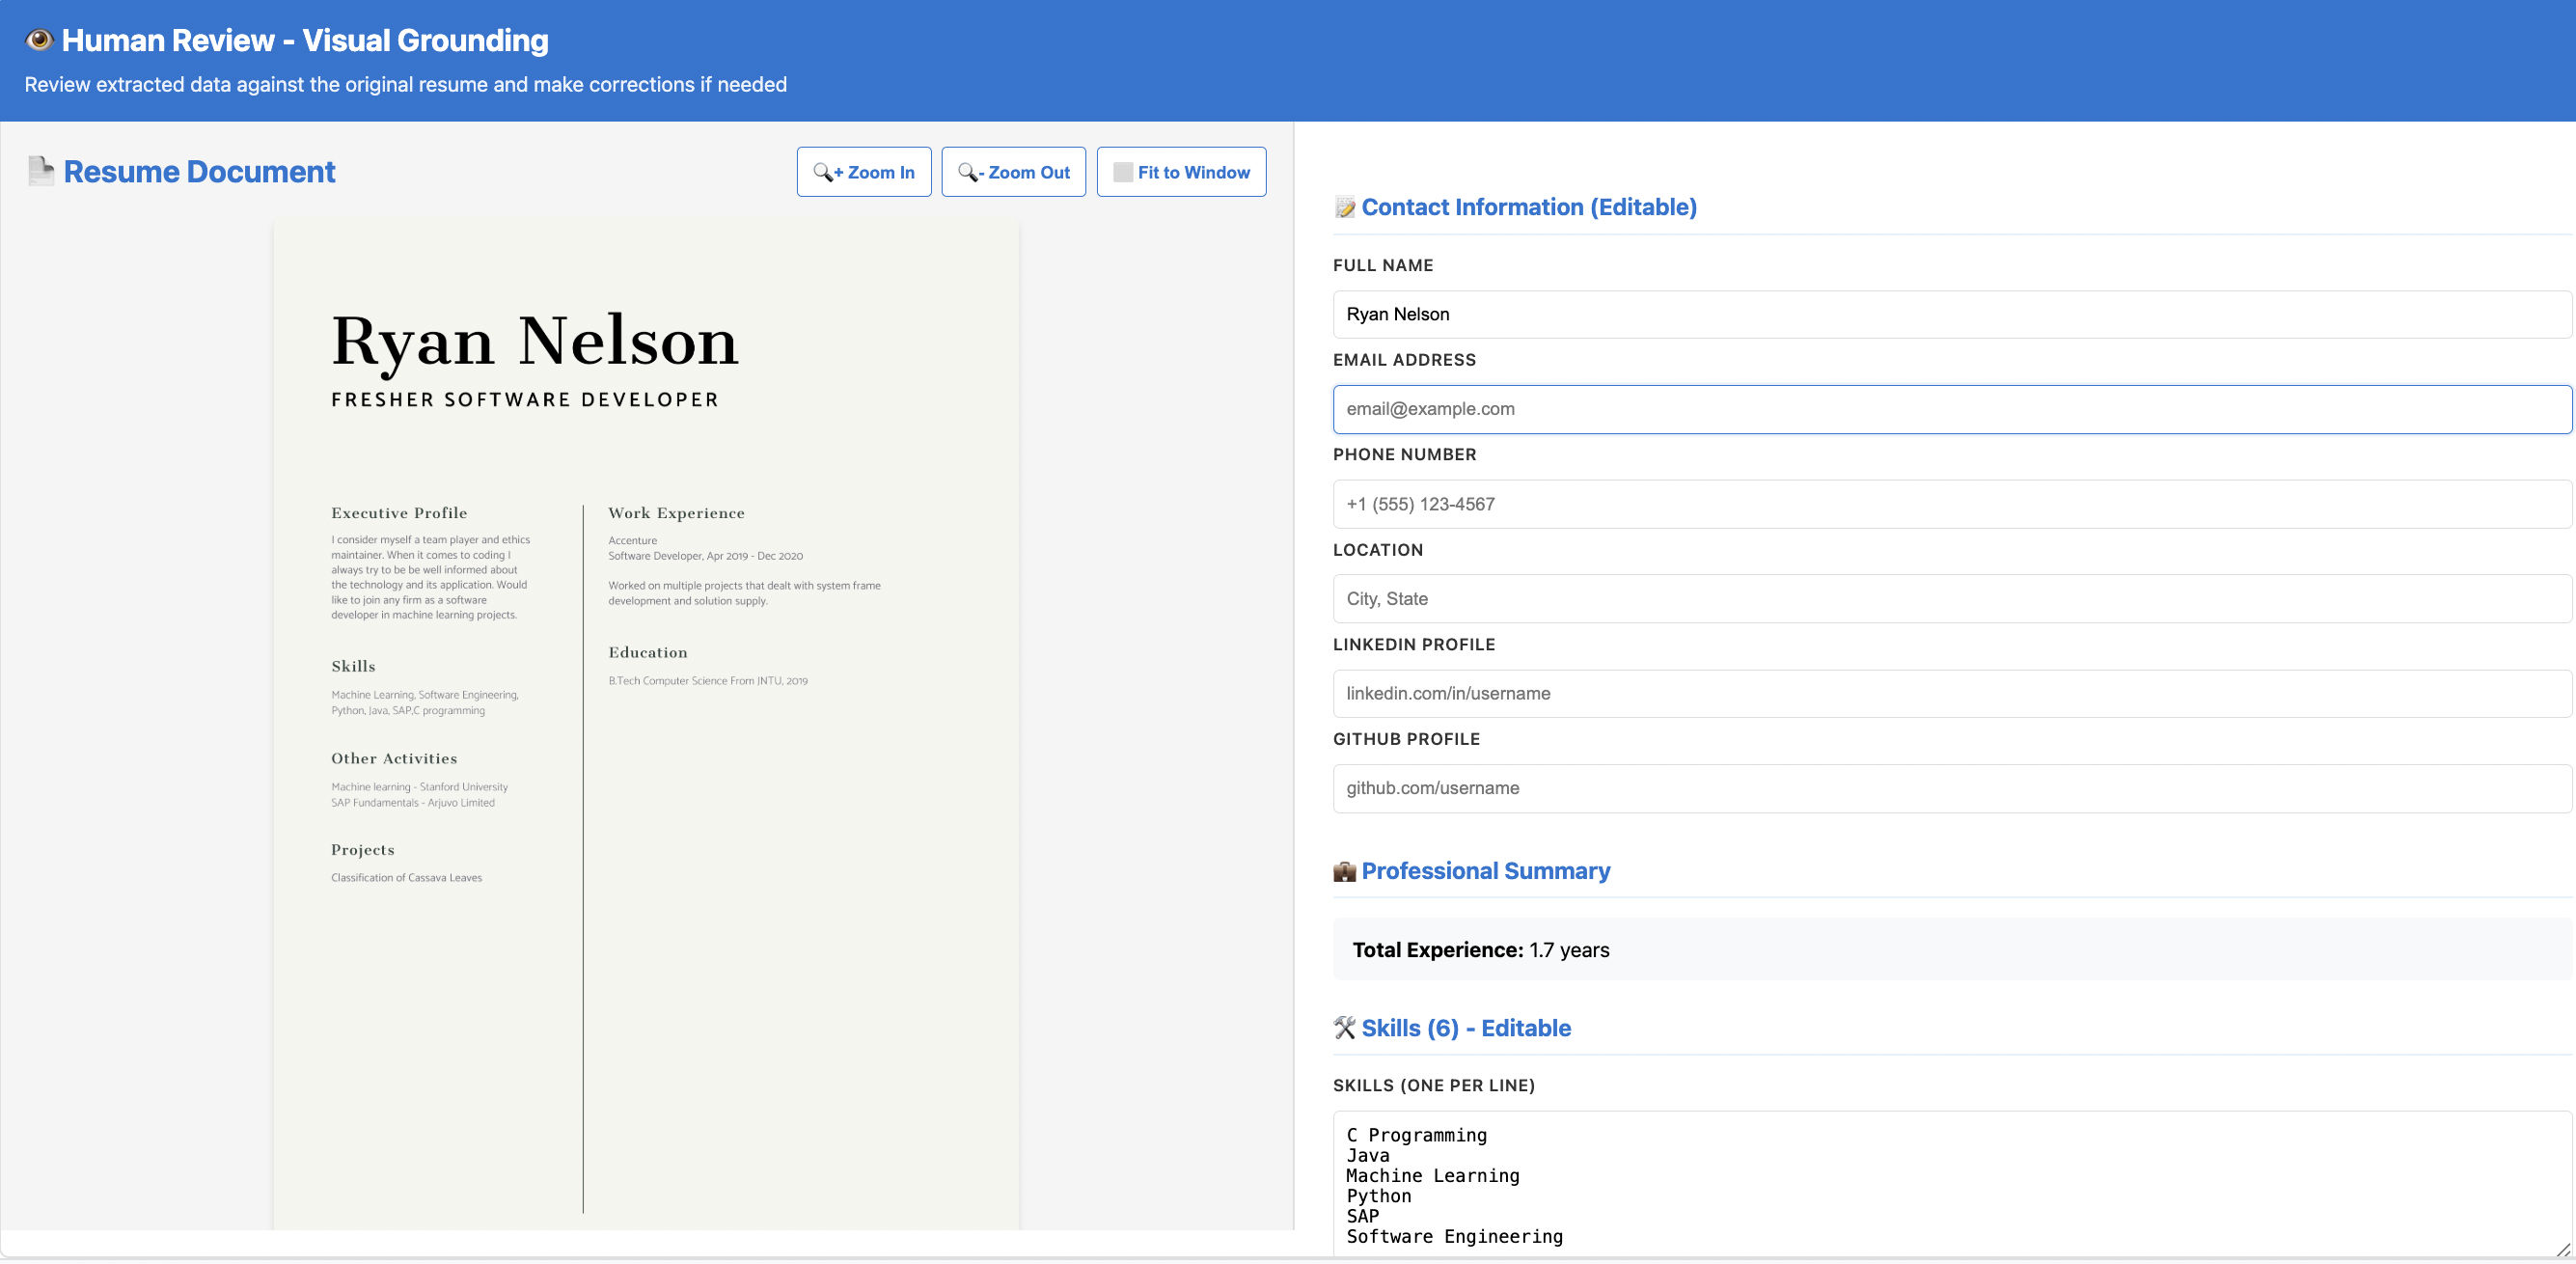

## Query Database

Let's query the database to see the stored records.

In [42]:
def query_database(db_path: str = "resume_ats.db"):
    """Query and display all candidates in the database"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Get all candidates
    cursor.execute('''
        SELECT id, name, email, phone, location, total_years_experience, created_at
        FROM candidates
        ORDER BY created_at DESC
    ''')
    
    candidates = cursor.fetchall()
    
    print("\n📊 CANDIDATES IN DATABASE")
    print("="*100)
    
    if not candidates:
        print("No candidates found in database.")
    else:
        print(f"{'ID':<5} {'Name':<25} {'Email':<30} {'Experience':<12} {'Created':<20}")
        print("-"*100)
        
        for candidate in candidates:
            cid, name, email, phone, location, exp, created = candidate
            # Handle None values safely
            name_str = (name[:24] if name else 'N/A')
            email_str = (email[:29] if email else 'N/A')
            exp_str = str(exp) if exp is not None else 'N/A'
            created_str = (created[:19] if created else 'N/A')
            print(f"{cid:<5} {name_str:<25} {email_str:<30} {exp_str:<12} {created_str:<20}")
        
        print("-"*100)
        print(f"Total candidates: {len(candidates)}")
    
    # Get skills for latest candidate
    if candidates:
        latest_id = candidates[0][0]
        cursor.execute('SELECT skill FROM skills WHERE candidate_id = ?', (latest_id,))
        skills = [row[0] for row in cursor.fetchall()]
        
        if skills:
            print(f"\n🛠️ Skills for candidate {latest_id} ({candidates[0][1]}):")
            print(", ".join(skills[:15]))
            if len(skills) > 15:
                print(f"... and {len(skills) - 15} more")
    
    conn.close()

# Query the database
query_database()


📊 CANDIDATES IN DATABASE
ID    Name                      Email                          Experience   Created             
----------------------------------------------------------------------------------------------------
9     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-26 10:14:10 
10    Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-26 10:14:10 
7     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-26 10:07:51 
8     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-26 10:07:51 
5     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-25 10:51:09 
6     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-25 10:51:09 
3     Ryan Nelson               N/A                            1.7          2025-12-25 10:48:43 
4     Ryan Nelson               N/A                            1.7          2025-12-25 10:48:43 
